# SARIMA Forecast of Gas and Electricity Use

This script uses the gas and electricity meter readings I've been taking over the last couple of years to predict the next years usage.  The one with the most variability is the gas, understandably; the electricity barely shifts and looks practically linear except for a small increase over the winter.

The idea is that with a forecast included in my spreadsheet, you have an idea of your actuals against forecast.  Nice!

Now, SARIMA modelling can deal with the inconsistent number of days between observations, but it was throwing up warnings all over the place, so I've engineered a feature by basically taking the available data and linearly interpolating for every day of the year between real readings, then resampling every 7th line to get a weekly reading.  In effect, this means that where there was a week where I didn't take a reading on a Thursday a linear interpolation is imputed, but where I did take one the actual reading is still present. 

This data is then modelled using a very simple and not very highly tuned SARIMAX model; the only tuning is to change the "s" parameter to 26, which means the model seasonality is 26 weeks in length.  Works well, but wasn't chosen using any ACF/PACF methods.

---
## 1.0 Package Import

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

---
## 2.0 Data Import

In [2]:
# Create column names for easy import
columns = ["Date", "Week", "Electricity (kWh)", "Gas (m3)", "Days in Period",
           "Total", "Electricity", "Cost In Period", "Cost Per Day", "Cumul. Use",
           "Total", "m3 Per/Day", "Gas", "Cost in Period", "Cost Per Day",
           "Cumul. Use"]

# Import the data from file and exclude the columns you don't need.
df = pd.read_excel("Energy Usage.xlsx", sheet_name="Data", skiprows=9, names=columns)
df = df[['Date','Electricity (kWh)', 'Gas (m3)']]

# Remove data before 2022, when weekly reading started.
df = df.loc[df['Date'] > "2022"].reset_index(drop=True)

df.tail()

,Date,Electricity (kWh),Gas (m3)
82,2023-10-12,13815,3892.425
83,2023-10-26,13878,3900.000
84,2023-11-02,13946,3908.449
85,2023-11-09,14016,3917.132
86,2023-11-16,14089,3938.313


---

## 3.0 Feature Engineering
Create a dataframe where readings are weekly - most of the time this is true (an actual reading each week), but sometimes a reading is missed or taken on a different day.

This is done by creating a date range starting at the first entry of the data and running to the last entry in the dataset.  Next, we merge the two frames together on the 'Date' column, which will leave a NaN value in most of the days.  We interpolate linearly between each real reading (creating a reading per day) and then resample the range to every 7th row, creating our "weekly reading".  Because we started on a Thursday and continue to take readings on Thursdays, most of these readings will be real with only a small number of interpolations.

In [3]:
# Create date range from 31/3/2022 until today
df_range = pd.date_range(start=df['Date'][0], end=df['Date'][len(df)-1], freq='D').to_frame().reset_index(drop=True)
df_range.columns = ["Date"]

# Merge the meter readings into the df_range table
df_range = pd.merge(left=df_range, right=df, how='outer', left_on='Date', right_on='Date')

# Interpolate the data between entries
df_range['Gas Int'] = df_range['Gas (m3)'].interpolate(method='linear')
df_range['Elec Int'] = df_range['Electricity (kWh)'].interpolate(method='linear')
df_range = df_range[['Date','Gas Int', 'Elec Int']]
df_range.set_index('Date', inplace=True)
df_range = df_range.iloc[::7,:]
df_range.head()

,Gas Int,Elec Int
Date,,
2022-03-31,3195.000,9692.0
2022-04-07,3207.000,9764.0
2022-04-14,3215.439,9836.0
2022-04-21,3220.408,9889.0
2022-04-28,3226.030,9950.0


---
## 4.0 Model Training/Testing

Split the data and then train a model; test it to see how it does.  To be honest, if the shape of the curve looks about right, it'll do.

In [4]:
# Split the data into training and testing sets
train_size = int(len(df_range) * 0.8)  # Adjust the split ratio as needed
train, test = df_range.iloc[:train_size], df_range.iloc[train_size:]

---
### 4.1 Gas Model

/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04985D+00    |proj g|=  1.74709D-01


 This problem is unconstrained.



At iterate    5    f=  1.85953D+00    |proj g|=  1.65943D-01

At iterate   10    f=  1.78372D+00    |proj g|=  1.54728D-02

At iterate   15    f=  1.78311D+00    |proj g|=  9.80051D-05

At iterate   20    f=  1.78311D+00    |proj g|=  4.27883D-04

At iterate   25    f=  1.78310D+00    |proj g|=  6.24503D-04

At iterate   30    f=  1.78309D+00    |proj g|=  1.47139D-04

At iterate   35    f=  1.78309D+00    |proj g|=  2.12382D-04

At iterate   40    f=  1.78309D+00    |proj g|=  5.12471D-04

At iterate   45    f=  1.78309D+00    |proj g|=  3.11307D-04

At iterate   50    f=  1.78308D+00    |proj g|=  5.18762D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/jon/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Gas Mean Squared Error (MSE): 28.05804161089969


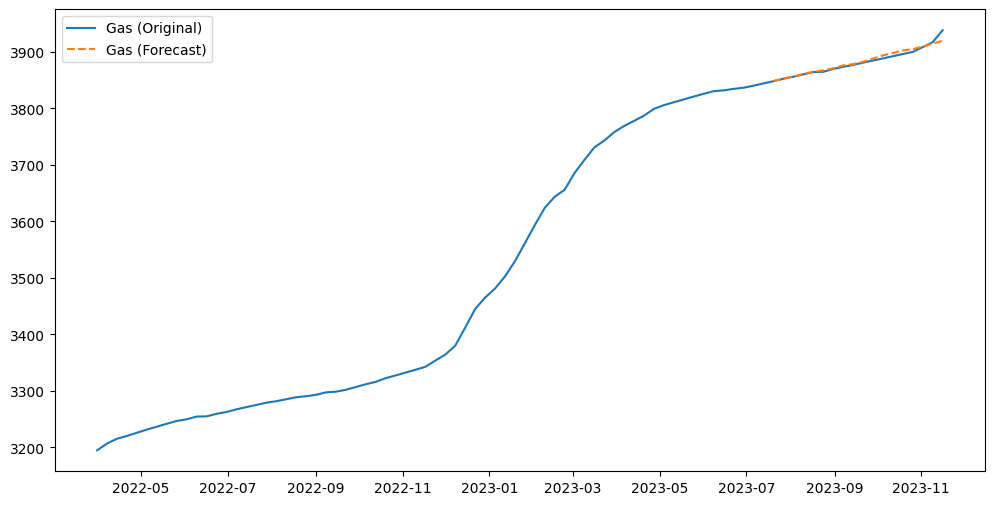

In [7]:
# Fit a SARIMA model for Gas
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 26  # Seasonal parameters

#Fit a SARIMA model for Gas
sarima_gas_model = SARIMAX(train['Gas Int'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_gas_result = sarima_gas_model.fit()

# Make predictions on the test set for Gas
gas_predictions = sarima_gas_result.get_forecast(steps=len(test))
gas_mse = mean_squared_error(test['Gas Int'], gas_predictions.predicted_mean)
print(f'Gas Mean Squared Error (MSE): {gas_mse}')

# Plot the original series and the forecasted values for Gas
plt.figure(figsize=(12, 6))
plt.plot(df_range['Gas Int'], label='Gas (Original)')
plt.plot(gas_predictions.predicted_mean, label='Gas (Forecast)', linestyle='--')
plt.legend()
plt.show()

---
### 4.2 Electricity Model

/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73135D+00    |proj g|=  1.99864D-01


 This problem is unconstrained.



At iterate    5    f=  2.65435D+00    |proj g|=  1.21870D-02

At iterate   10    f=  2.60089D+00    |proj g|=  7.65955D-02

At iterate   15    f=  2.55402D+00    |proj g|=  4.64542D-02

At iterate   20    f=  2.54958D+00    |proj g|=  6.50049D-04

At iterate   25    f=  2.54958D+00    |proj g|=  2.91886D-04

At iterate   30    f=  2.54957D+00    |proj g|=  6.90581D-04

At iterate   35    f=  2.54956D+00    |proj g|=  1.21820D-03

At iterate   40    f=  2.54955D+00    |proj g|=  1.06240D-03

At iterate   45    f=  2.54955D+00    |proj g|=  1.62645D-03

At iterate   50    f=  2.54954D+00    |proj g|=  4.25805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/jon/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Electricity Mean Squared Error (MSE): 523.917670737987


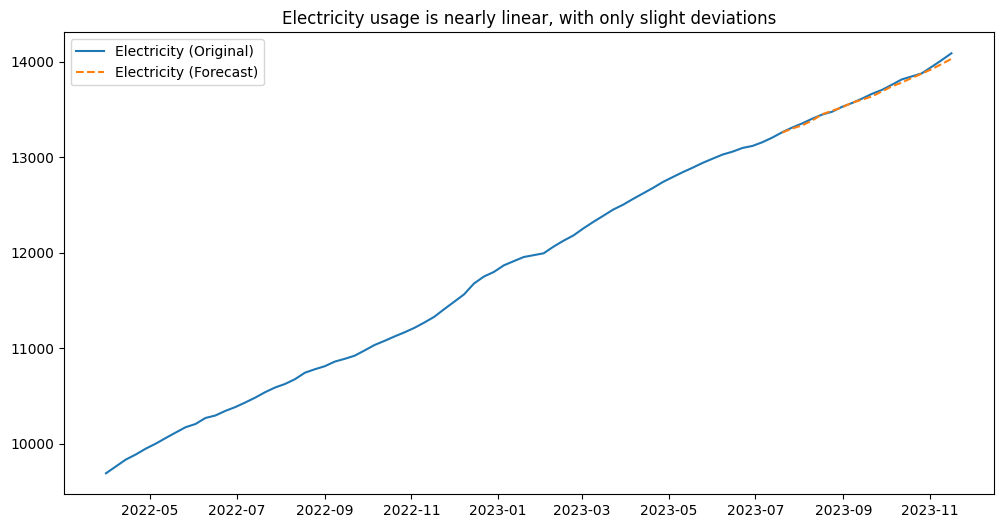

In [8]:
# Fit a SARIMA model for Electricity
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 26  # Seasonal parameters

# Fit a SARIMA model for Electricity
sarima_electricity_model = SARIMAX(train['Elec Int'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_electricity_result = sarima_electricity_model.fit()

# Make predictions on the test set for Electricity
electricity_predictions = sarima_electricity_result.get_forecast(steps=len(test))
electricity_mse = mean_squared_error(test['Elec Int'], electricity_predictions.predicted_mean)
print(f'Electricity Mean Squared Error (MSE): {electricity_mse}')

# Plot the original series and the forecasted values for Electricity
plt.figure(figsize=(12, 6))
plt.plot(df_range['Elec Int'], label='Electricity (Original)')
plt.plot(electricity_predictions.predicted_mean, label='Electricity (Forecast)', linestyle='--')
plt.title('Electricity usage is nearly linear, with only slight deviations')
plt.legend()
plt.show()

---
## 5.0 Final Modelling

Using what we learned from setting parameters in the training/testing set, use all of the available data to train another model to predict the next few period of time.

### 5.1 Gas final model

In [9]:
# Set the number of weeks into the future you want predicted for
prediction_steps = 8

In [10]:
# Fit a SARIMA model for Gas
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 26  # Seasonal parameters

sarima_gas_model = SARIMAX(df_range['Gas Int'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_gas_result = sarima_gas_model.fit()

/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31079D+00    |proj g|=  2.99239D-01

At iterate    5    f=  2.15427D+00    |proj g|=  1.52616D-01

At iterate   10    f=  1.99035D+00    |proj g|=  2.51278D-02

At iterate   15    f=  1.98907D+00    |proj g|=  4.01963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   9.195D-07   1.989D+00
  F =   1.9890623755083598     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [26]:
gas_predictions.predicted_mean

2023-11-23    3962.726607
2023-11-30    3985.005552
2023-12-07    4011.139739
2023-12-14    4050.102630
2023-12-21    4089.771689
2023-12-28    4116.827997
2024-01-04    4139.412113
2024-01-11    4165.911387
Freq: W-THU, Name: predicted_mean, dtype: float64

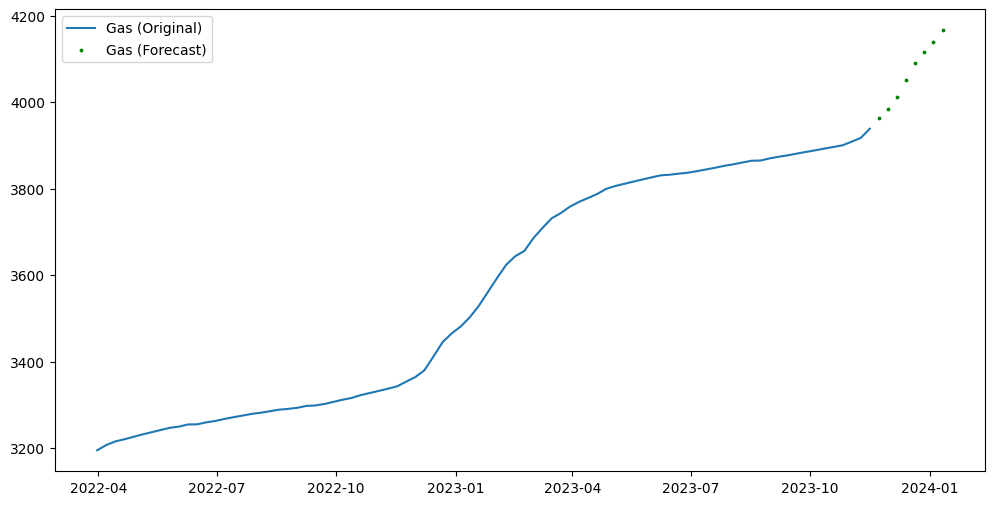

In [22]:
# Make predictions on the test set for Gas
gas_predictions = sarima_gas_result.get_forecast(steps=prediction_steps)

# Plot the original series and the forecasted values for Gas
plt.figure(figsize=(12, 6))
plt.plot(df_range['Gas Int'], label='Gas (Original)')
plt.scatter(gas_predictions.predicted_mean.index, gas_predictions.predicted_mean, label='Gas (Forecast)', s=3, color='green')
plt.legend()
plt.show()

---
### 5.2 Electricity Final Model

In [186]:
# Fit a SARIMA model for Electricity
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 26  # Seasonal parameters

# Fit a SARIMA model for Electricity
sarima_electricity_model = SARIMAX(df_range['Elec Int'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_electricity_result = sarima_electricity_model.fit()

/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/jon/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04060D+00    |proj g|=  2.54644D-01

At iterate    5    f=  2.95240D+00    |proj g|=  2.63583D-02

At iterate   10    f=  2.91468D+00    |proj g|=  9.35539D-02

At iterate   15    f=  2.88486D+00    |proj g|=  5.84172D-03

At iterate   20    f=  2.87527D+00    |proj g|=  1.38284D-02

At iterate   25    f=  2.86492D+00    |proj g|=  1.53319D-02

At iterate   30    f=  2.86387D+00    |proj g|=  8.43775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

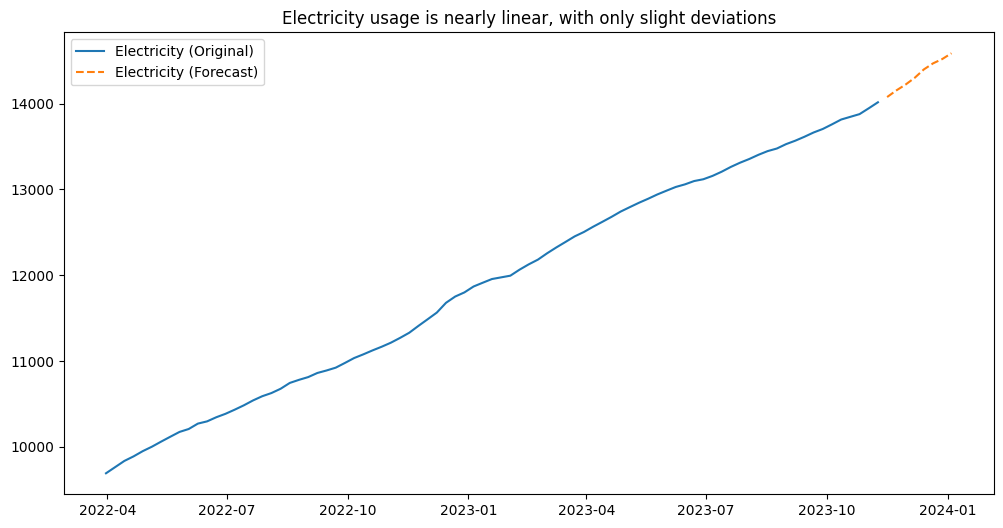

In [188]:
# Make predictions on the test set for Electricity
electricity_predictions = sarima_electricity_result.get_forecast(steps=prediction_steps)

# Plot the original series and the forecasted values for Electricity
plt.figure(figsize=(12, 6))
plt.plot(df_range['Elec Int'], label='Electricity (Original)')
plt.plot(electricity_predictions.predicted_mean, label='Electricity (Forecast)', linestyle='--')
plt.title('Electricity usage is nearly linear, with only slight deviations')
plt.legend()
plt.show()

## 6.0 Conclusion

Modelling this way seems to be quite successful with even minimal tuning.  A bit more focus might be valuable, but this is fine for now.

In [192]:
df_predictions = pd.DataFrame([gas_predictions.predicted_mean, electricity_predictions.predicted_mean]).transpose()
df_predictions

,predicted_mean,predicted_mean
2023-11-16,3925.569224,14076.919056
2023-11-23,3938.904445,14154.077102
2023-11-30,3950.548064,14221.782172
2023-12-07,3968.116778,14301.073872
2023-12-14,3999.515948,14399.213831
2023-12-21,4033.533767,14469.729925
2023-12-28,4054.863704,14520.020929
2024-01-04,4072.033497,14587.165445
2024-01-11,4093.597979,NaN
2024-01-18,4120.054384,NaN
